### Multi-Class Model for Kaggle Tabular Playground Series June 2021 Using Python and TensorFlow
### David Lowe
### July 15, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground June 2021 dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset used for this competition is synthetic but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the category on an eCommerce product given various attributes about the listing. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The performance of the cross-validated TensorFlow models achieved an average logarithmic loss benchmark of 1.7669 after running for ten epochs. When we applied the final model to Kaggle's test dataset, the model achieved a logarithmic loss score of 1.7638.

CONCLUSION: In this iteration, the TensorFlow model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 June Data Set

Dataset ML Model: Multi-Class classification with categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-jun-2021/

One potential source of performance benchmark: https://www.kaggle.com/c/tabular-playground-series-jun-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sat Jul 10 01:00:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

### 1.b) Set up the controlling parameters and functions

In [39]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 10
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['categorical_crossentropy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
DEFAULT_CLASSIFIER = 'softmax'
MAX_EPOCHS = 10
BATCH_SIZE = 32
NUM_CLASSES = 9

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.5.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [10]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id  feature_0  feature_1  ...  feature_73  feature_74   target
0   0          0          0  ...           0           0  Class_6
1   1          0          0  ...           1           0  Class_6
2   2          0          0  ...           0           0  Class_2
3   3          0          0  ...           3           0  Class_8
4   4          1          0  ...           0           0  Class_2

[5 rows x 77 columns]


In [12]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 77 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          200000 non-null  int64 
 1   feature_0   200000 non-null  int64 
 2   feature_1   200000 non-null  int64 
 3   feature_2   200000 non-null  int64 
 4   feature_3   200000 non-null  int64 
 5   feature_4   200000 non-null  int64 
 6   feature_5   200000 non-null  int64 
 7   feature_6   200000 non-null  int64 
 8   feature_7   200000 non-null  int64 
 9   feature_8   200000 non-null  int64 
 10  feature_9   200000 non-null  int64 
 11  feature_10  200000 non-null  int64 
 12  feature_11  200000 non-null  int64 
 13  feature_12  200000 non-null  int64 
 14  feature_13  200000 non-null  int64 
 15  feature_14  200000 non-null  int64 
 16  feature_15  200000 non-null  int64 
 17  feature_16  200000 non-null  int64 
 18  feature_17  200000 non-null  int64 
 19  feature_18  200000 non-

In [13]:
print(df_dataset_import.describe())

                  id      feature_0  ...    feature_73     feature_74
count  200000.000000  200000.000000  ...  200000.00000  200000.000000
mean    99999.500000       0.972710  ...       2.94021       0.632005
std     57735.171256       3.941836  ...      10.78465       3.925310
min         0.000000       0.000000  ...       0.00000       0.000000
25%     49999.750000       0.000000  ...       0.00000       0.000000
50%     99999.500000       0.000000  ...       0.00000       0.000000
75%    149999.250000       1.000000  ...       1.00000       0.000000
max    199999.000000      61.000000  ...     130.00000      52.000000

[8 rows x 76 columns]


In [14]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
             ..
feature_71    0
feature_72    0
feature_73    0
feature_74    0
target        0
Length: 77, dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [15]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# # Convert columns from one data type to another
# train_feature_list = list(df_dataset_import.columns)
# for feature in train_feature_list:
#     df_dataset_import[feature] = df_dataset_import[feature].astype('category')

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   feature_0  feature_1  feature_2  ...  feature_73  feature_74   target
0          0          0          6  ...           0           0  Class_6
1          0          0          0  ...           1           0  Class_6
2          0          0          0  ...           0           0  Class_2
3          0          0          7  ...           3           0  Class_8
4          1          0          0  ...           0           0  Class_2

[5 rows x 76 columns]


In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 76 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   feature_0   200000 non-null  int64 
 1   feature_1   200000 non-null  int64 
 2   feature_2   200000 non-null  int64 
 3   feature_3   200000 non-null  int64 
 4   feature_4   200000 non-null  int64 
 5   feature_5   200000 non-null  int64 
 6   feature_6   200000 non-null  int64 
 7   feature_7   200000 non-null  int64 
 8   feature_8   200000 non-null  int64 
 9   feature_9   200000 non-null  int64 
 10  feature_10  200000 non-null  int64 
 11  feature_11  200000 non-null  int64 
 12  feature_12  200000 non-null  int64 
 13  feature_13  200000 non-null  int64 
 14  feature_14  200000 non-null  int64 
 15  feature_15  200000 non-null  int64 
 16  feature_16  200000 non-null  int64 
 17  feature_17  200000 non-null  int64 
 18  feature_18  200000 non-null  int64 
 19  feature_19  200000 non-

In [17]:
print(df_dataset_import.describe())

           feature_0      feature_1  ...    feature_73     feature_74
count  200000.000000  200000.000000  ...  200000.00000  200000.000000
mean        0.972710       1.168365  ...       2.94021       0.632005
std         3.941836       3.993407  ...      10.78465       3.925310
min         0.000000       0.000000  ...       0.00000       0.000000
25%         0.000000       0.000000  ...       0.00000       0.000000
50%         0.000000       0.000000  ...       0.00000       0.000000
75%         1.000000       1.000000  ...       1.00000       0.000000
max        61.000000      51.000000  ...     130.00000      52.000000

[8 rows x 75 columns]


In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
             ..
feature_71    0
feature_72    0
feature_73    0
feature_74    0
target        0
Length: 76, dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = total_column_count

In [20]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (200000, 76) df_features_train.shape: (200000, 75) df_target_train.shape: (200000,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

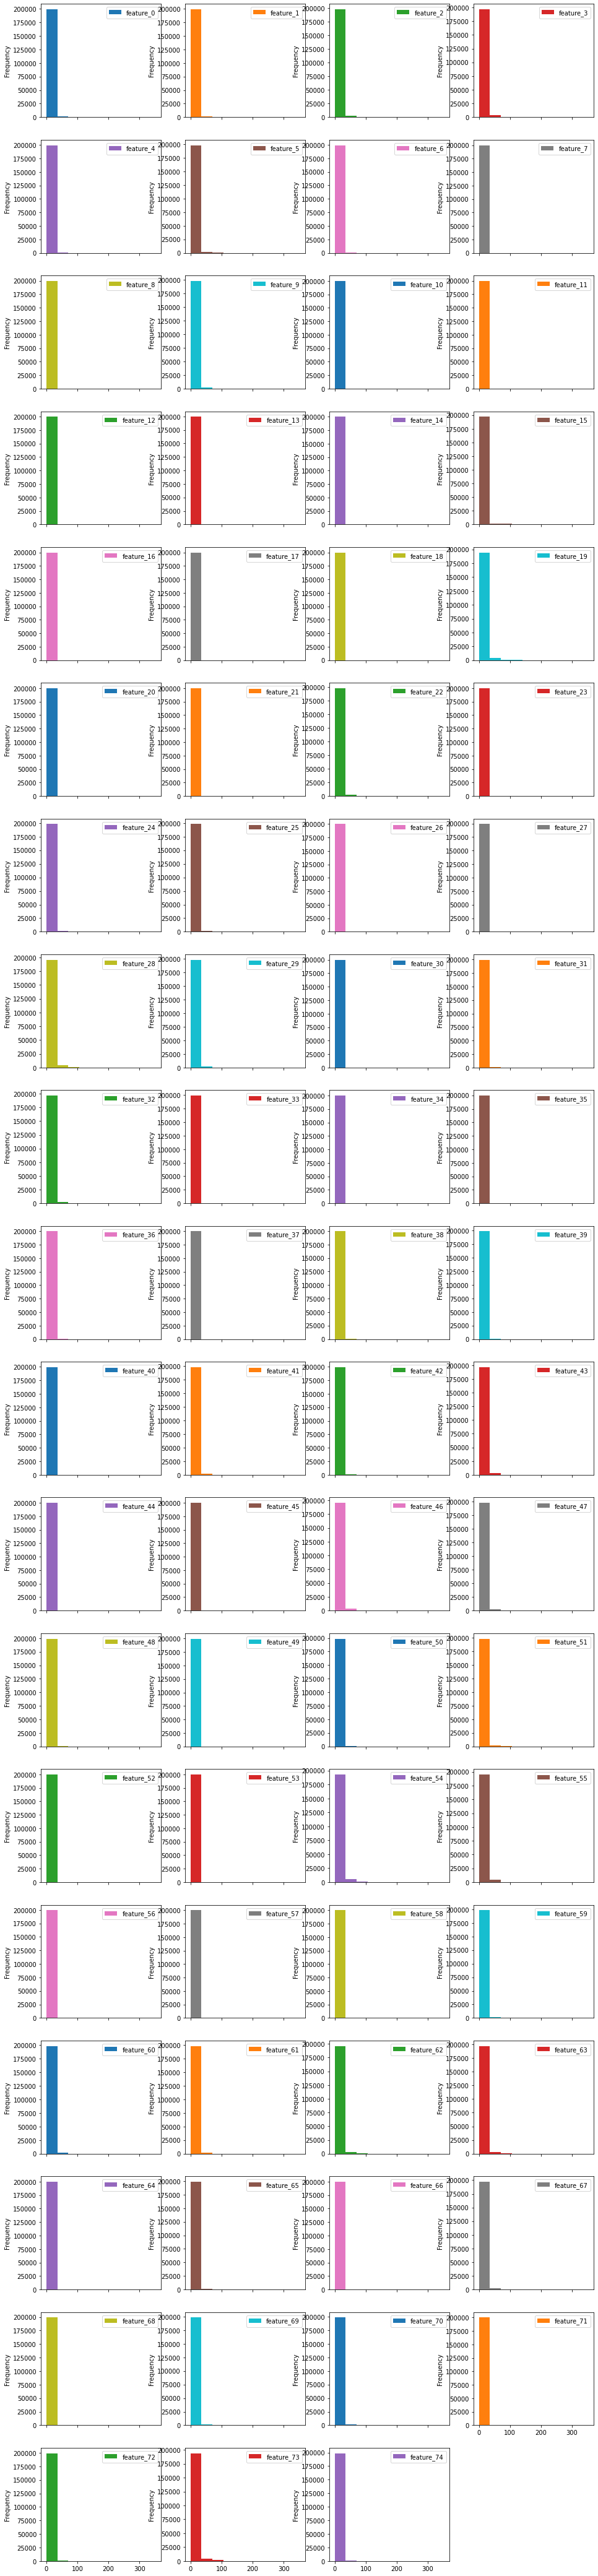

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

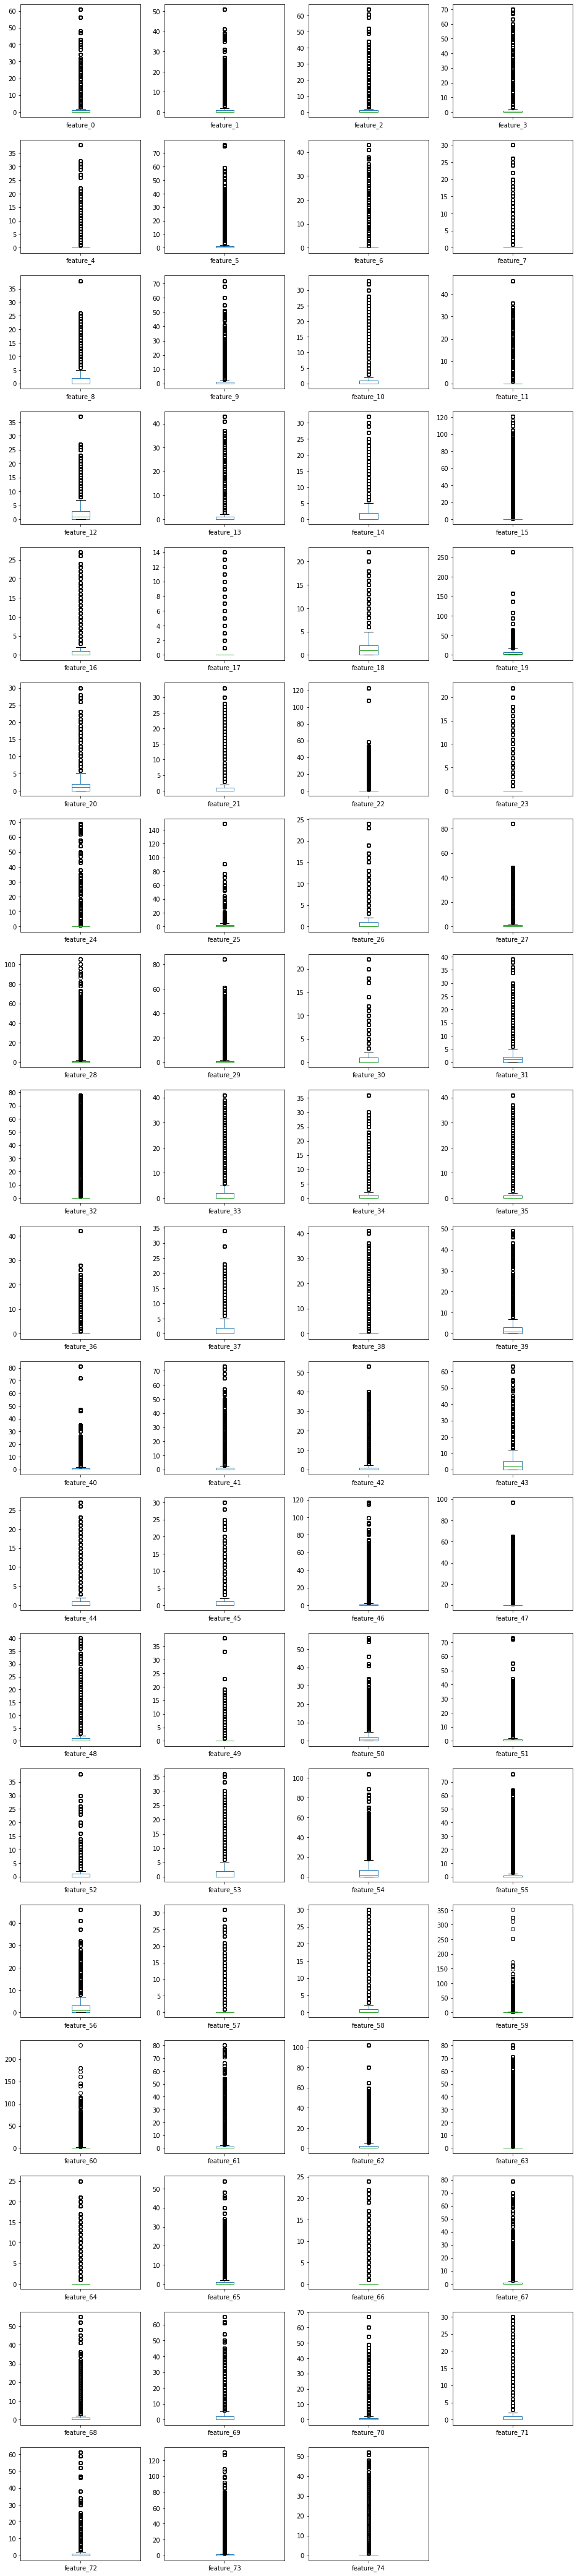

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

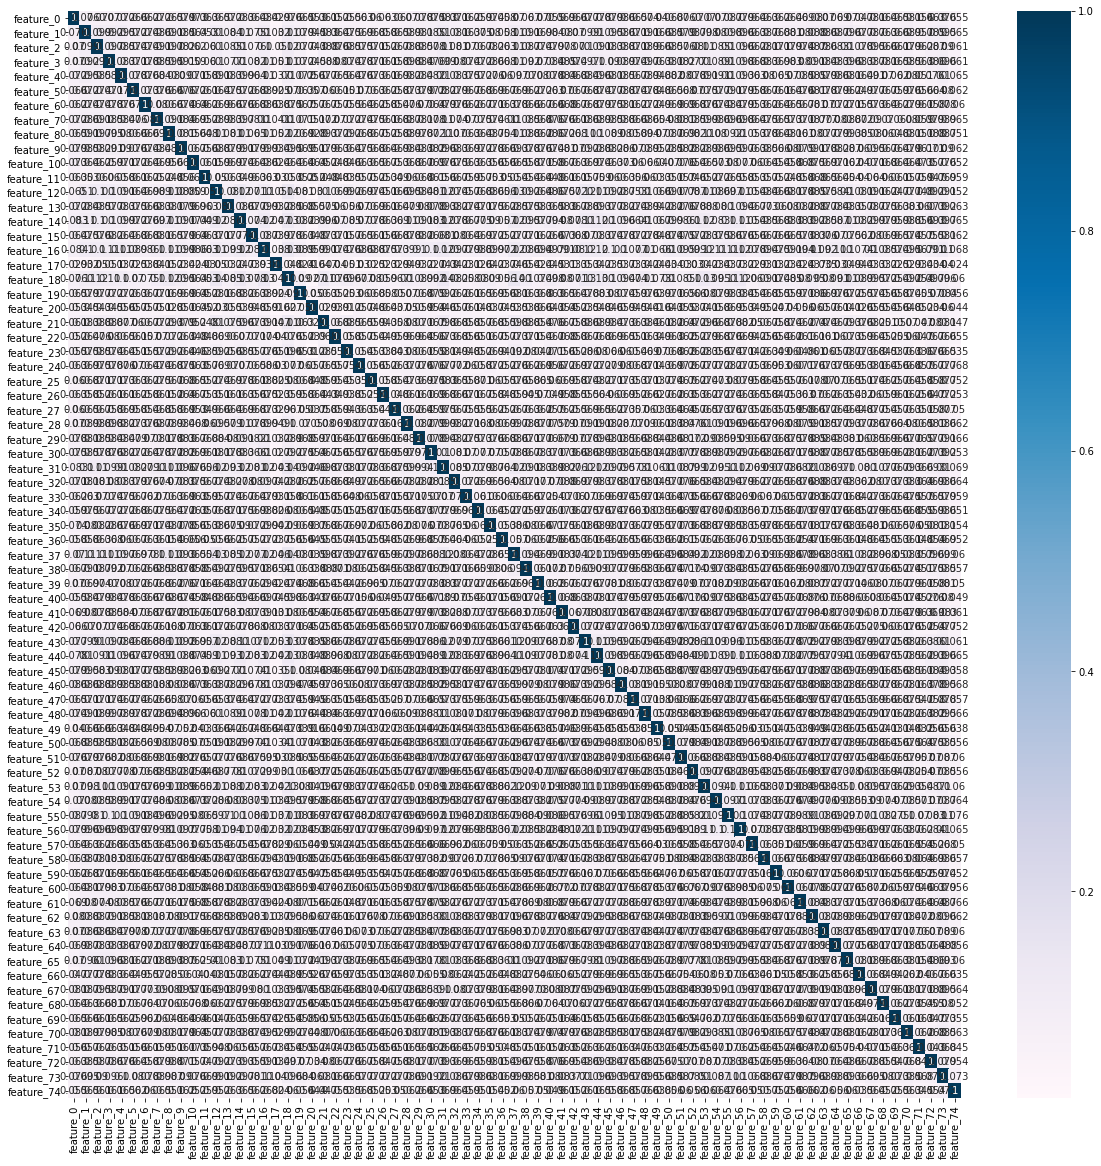

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [29]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [30]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    # ('imputer', impute.SimpleImputer(strategy="median")),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    # ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 75
Number of categorical columns: 0
Total number of columns in the feature dataframe: 75


In [31]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (200000, 75) to array_features_train.shape: (200000, 75)


### 3.c) Training Data Balancing

In [32]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [33]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [34]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
label_encoder = preprocessing.LabelEncoder()
array_target_train = keras.utils.to_categorical(label_encoder.fit_transform(df_target_train))
print(label_encoder.classes_)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']
array_features_train.shape: (200000, 75) array_target_train.shape: (200000, 9)


In [35]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [36]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=array_features_train.shape[1], output_param=NUM_CLASSES, layer1_nodes=512, layer2_nodes=384, layer3_nodes=256, layer4_nodes=128, layer5_nodes=64,
                    layer1_dropout=0.25, layer2_dropout=0.25, layer3_dropout=0.25, layer4_dropout=0.25, layer5_dropout=0.25,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=DEFAULT_CLASSIFIER,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(layer4_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dropout(layer4_dropout),
        keras.layers.Dense(layer5_nodes, activation='relu', kernel_initializer=init_param),
        # keras.layers.Dropout(layer5_dropout),
        keras.layers.Dense(output_param, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [41]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_features_train):
    feature_train, feature_validation = array_features_train[train_ix], array_features_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    reset_random()
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=1)[1]
    iteration = iteration + 1
    print('Score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model scorer from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

625/625 [==============================] - 1s 2ms/step - loss: 1.7712 - categorical_crossentropy: 1.7712
Score from iteration 1 >>> 1.7712
625/625 [==============================] - 1s 2ms/step - loss: 1.7684 - categorical_crossentropy: 1.7684
Score from iteration 2 >>> 1.7684
625/625 [==============================] - 1s 2ms/step - loss: 1.7655 - categorical_crossentropy: 1.7655
Score from iteration 3 >>> 1.7655
625/625 [==============================] - 1s 2ms/step - loss: 1.7802 - categorical_crossentropy: 1.7802
Score from iteration 4 >>> 1.7802
625/625 [==============================] - 1s 2ms/step - loss: 1.7638 - categorical_crossentropy: 1.7638
Score from iteration 5 >>> 1.7638
625/625 [==============================] - 1s 2ms/step - loss: 1.7598 - categorical_crossentropy: 1.7598
Score from iteration 6 >>> 1.7598
625/625 [==============================] - 1s 2ms/step - loss: 1.7655 - categorical_crossentropy: 1.7655
Score from iteration 7 >>> 1.7655
625/625 [==================

In [ ]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [42]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [43]:
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=2, verbose=1, factor=0.5, min_lr=0.000001)
final_model = create_nn_model()
final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[learning_rate_reduction], verbose=1)
final_model.summary()

Epoch 1/10
6250/6250 [==============================] - 17s 3ms/step - loss: 1.7983 - categorical_crossentropy: 1.7983
Epoch 2/10
6250/6250 [==============================] - 16s 3ms/step - loss: 1.7787 - categorical_crossentropy: 1.7787
Epoch 3/10
6250/6250 [==============================] - 16s 3ms/step - loss: 1.7737 - categorical_crossentropy: 1.7737
Epoch 4/10
6250/6250 [==============================] - 16s 3ms/step - loss: 1.7697 - categorical_crossentropy: 1.7697
Epoch 5/10
6250/6250 [==============================] - 16s 3ms/step - loss: 1.7665 - categorical_crossentropy: 1.7665
Epoch 6/10
6250/6250 [==============================] - 16s 3ms/step - loss: 1.7633 - categorical_crossentropy: 1.7633
Epoch 7/10
6250/6250 [==============================] - 16s 3ms/step - loss: 1.7613 - categorical_crossentropy: 1.7613
Epoch 8/10
6250/6250 [==============================] - 16s 3ms/step - loss: 1.7590 - categorical_crossentropy: 1.7590
Epoch 9/10
6250/6250 [==========================

### 6.b) Load Test Dataset and Prepare the Submission File

In [44]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

       id  feature_0  feature_1  ...  feature_72  feature_73  feature_74
0  200000          0          0  ...           0           0           0
1  200001          1          2  ...           3           0           0
2  200002          0          1  ...           2           0           0
3  200003          0          0  ...           4           0           0
4  200004          0          0  ...           0           1           0

[5 rows x 76 columns]


In [45]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

       id
0  200000
1  200001
2  200002
3  200003
4  200004


In [46]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# # Convert columns from one data type to another
# test_feature_list = list(df_features_test.columns)
# for feature in test_feature_list:
#     df_features_test[feature] = df_features_test[feature].astype('category')

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

   feature_0  feature_1  feature_2  ...  feature_72  feature_73  feature_74
0          0          0          0  ...           0           0           0
1          1          2          0  ...           3           0           0
2          0          1          7  ...           2           0           0
3          0          0          0  ...           4           0           0
4          0          0          5  ...           0           1           0

[5 rows x 75 columns]


In [47]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (100000, 75) to array_features_test.shape: (100000, 75)


In [48]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[[0.06668072 0.37044722 0.1561077  ... 0.02463242 0.05864678 0.13016418]
 [0.03709261 0.03726342 0.03105799 ... 0.08846263 0.37593883 0.10266555]
 [0.02986561 0.03888734 0.02735638 ... 0.04307804 0.21259055 0.07554137]
 ...
 [0.05075618 0.22935882 0.12962349 ... 0.05149041 0.1443521  0.1649368 ]
 [0.03632096 0.03376278 0.02660199 ... 0.06903433 0.32604513 0.09149453]
 [0.03920695 0.08296283 0.06119098 ... 0.06840801 0.25933012 0.12645304]]


In [49]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021jun/sample_submission.csv'
df_sample_submission = pd.read_csv(dataset_path, index_col=False)
df_sample_submission.drop(columns=['id'], inplace=True)
submission_header = list(df_sample_submission.columns)
print(submission_header)

['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9']


In [50]:
df_kaggle_submission[submission_header] = test_predictions
print(df_kaggle_submission.head())

       id   Class_1   Class_2   Class_3  ...   Class_6   Class_7   Class_8   Class_9
0  200000  0.066681  0.370447  0.156108  ...  0.149168  0.024632  0.058647  0.130164
1  200001  0.037093  0.037263  0.031058  ...  0.295735  0.088463  0.375939  0.102666
2  200002  0.029866  0.038887  0.027356  ...  0.549112  0.043078  0.212591  0.075541
3  200003  0.043131  0.091975  0.067759  ...  0.249956  0.083046  0.275623  0.141144
4  200004  0.043169  0.129184  0.090200  ...  0.250420  0.067274  0.223827  0.153608

[5 rows x 10 columns]


In [51]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210710-0133.csv


In [52]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [53]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:31:07.364911
